In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from collections import Counter


# Prepare Data

In [7]:
# ############################################
# STEP 1: Load data
# just load data and merge in one dataframe
# ############################################

dir_name = ""
anime = pd.read_csv(f"{dir_name}anime.csv")
rating = pd.read_csv(f"{dir_name}rating.csv")
data = pd.merge(rating, anime, on='anime_id')
data.rename(columns={'rating_x': 'user_rating', 'rating_y': 'anime_rating'}, inplace=True)

# free memory remove anime and rating
del anime
del rating

# ############################################
# STEP 2: Data cleaning
# ############################################

#   a)Remove data with missing values
#   b)Remove data with user_rating = -1 if we have a -1 it means that the user has watched the anime
#     but has not rated it so we does not have any information
#   c)Remove users with less than 10 ratings, they have not a lot of data so we can't extract good information
#     and also they increase the dimenionality of the data so:  no information more big matrix is bad

data.dropna(inplace=True)
data = data[data['user_rating'] != -1]
data = data.groupby('user_id').filter(lambda x: len(x) >= 10)


# ############################################
# STEP 3: Normalize user ratings
# all users are different so we normalize the ratings of the users to have a common scale
# idea is to have a scale from -1 to 1 where -1 is correspondent to 0 and 1 is the best rating for the user
# NOTE: we need to use not 0 for mean or in futur is counted as a missing value (we use 0 to fill pivot table)
# ############################################

# a) we compute mean and max rating for each user
# b) we normalize the rating of the user with the formula:

user_stats = data.groupby('user_id')['user_rating'].agg(['mean', 'max']).rename(columns={'mean': 'mean_rating', 'max': 'max_rating'})
data = data.merge(user_stats, on='user_id')

def normalize_rating(row):
    if row['user_rating'] < row['mean_rating']:
        if row['mean_rating'] == 0:
            return -1
        if -1 * (row['mean_rating'] - row['user_rating']) / row['mean_rating'] > 0 :
            print("ERROR")
        return -1 * (row['mean_rating'] - row['user_rating']) / row['mean_rating']
    else:
        if row['max_rating'] == row['mean_rating']: 
            return 0.01 
        return (row['user_rating'] - row['mean_rating']) / (row['max_rating'] - row['mean_rating'])

data['importance'] = data.apply(normalize_rating, axis=1)

# remove useless columns so we manage better the memory
data.drop(columns=['anime_rating', 'members', 'type', 'max_rating', 'mean_rating'], inplace=True)

data.head()



,user_id,anime_id,user_rating,name,genre,episodes,importance
0,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",220,0.178571
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",12,-0.206897
2,3,9919,8,Ao no Exorcist,"Action, Demons, Fantasy, Shounen, Supernatural",25,0.178571
3,3,11737,7,Ao no Exorcist Movie,"Action, Demons, Fantasy, Shounen, Supernatural",1,-0.074713
4,3,11757,9,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",25,0.589286


# Build model

In [8]:
# ############################################
# STEP 1: Split data
# ############################################

# We choose a 5% of the users as test users because we prefer use more information for the training

# First things we need to pivot the data to have a matrix with users as rows and anime as columns
# after we get 5% of the users as test users

user_anime_matrix = data.pivot_table(index='user_id', columns='anime_id', values='importance').fillna(0)
user_id_test = user_anime_matrix.sample(frac=0.05, random_state=42).index

print("Total users:", len(user_anime_matrix), "      Test users:", len(user_id_test) )

# ############################################
# STEP 2: Compute anime-anime similarity matrix
# ############################################

# Idea: we will find similarity between anime based on the importance (normalized rating ) of the users
# we use only user that rated an anime with importance > 0.5 (NOTE: importance is normalized rating so 0.5 is a good rating)
# with this raccomender system we will compute not only the similarity but also the popolarity of the anime
# Normally if you like an anime you will watch also similar anime but a similar good and normally a good is given by popularity (a bad anime is not popular)
# We also remove at the end the diagonal of the matrix because we don't want to have similarity with itself useless reccomand a anime to watch the same anime :)
# we also compute the vote count for each anime in case we need it

high_importance_threshold = 0.5
anime_anime_matrix = pd.DataFrame(0.0, index=user_anime_matrix.columns, columns=user_anime_matrix.columns, dtype=float)
anime_vote_count_matrix = pd.DataFrame(0, index=user_anime_matrix.columns, columns=user_anime_matrix.columns, dtype=int)

# progress bar just for us (to understand how much time we need to compute the matrix) more easy to wait if we know how much time we need :)
total_to_compute = len(user_anime_matrix.columns)
pbar = tqdm(total=total_to_compute, desc="Processing Anime")

# for each anime we compute 
# first we get the users that rated the anime with importance > 0.5
# then we sum the importance of the users that rated the anime
# we also count the number of votes for the anime
# we store the sum of the importance and the vote count in the matrix

for anime_id in user_anime_matrix.columns:
    high_importance_users = user_anime_matrix[(user_anime_matrix[anime_id] > high_importance_threshold) & (~user_anime_matrix.index.isin(user_id_test))]

    anime_vectors_sum = high_importance_users.sum(axis=0)
    anime_anime_matrix.loc[anime_id] = anime_vectors_sum
    
    anime_vote_counts = high_importance_users.astype(bool).sum(axis=0)
    anime_vote_count_matrix.loc[anime_id] = anime_vote_counts

    pbar.update(1)

pbar.close()

# last step we remove the diagonal of the matrix because we don't want to have similarity with itself
np.fill_diagonal(anime_anime_matrix.values, 0)
np.fill_diagonal(anime_vote_count_matrix.values, 0)

# in caso to speedup the computation we can save the matrix in a file and load it when we need it
anime_anime_matrix.to_csv(f"{dir_name}anime_anime_matrix.csv")

Total users: 55118       Test users: 2756


Processing Anime:   0%|          | 0/9891 [00:00<?, ?it/s]

# Testing

### testing 1: check how good is raccomandation respect single anime
we will check how good is with a popular anime like Hunte x Hunter and we will also check with a niche anime

Anime name of most 10 similar animes to animeHunter x Hunter: Greed Island
1         Fullmetal Alchemist: Brotherhood
6                   Hunter x Hunter (2011)
13      Code Geass: Hangyaku no Lelouch R2
19         Code Geass: Hangyaku no Lelouch
40                              Death Note
112                        Hunter x Hunter
145                    Hunter x Hunter OVA
146    Hunter x Hunter: Greed Island Final
Name: name, dtype: object
Number of users that have seen the anime: 485
Mean rating of the users: 9.61921965317919


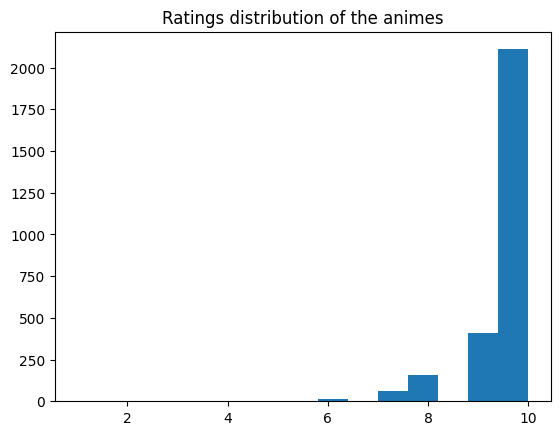

Anime name of most 10 similar animes to animeKaiba
15                      Sen to Chihiro no Kamikakushi
22                                       Cowboy Bebop
24                                      Mononoke Hime
28                                           Mushishi
29                         Tengen Toppa Gurren Lagann
84                                           Baccano!
130    Neon Genesis Evangelion: The End of Evangelion
211                           Neon Genesis Evangelion
Name: name, dtype: object
Number of users that have seen the anime: 179
Mean rating of the users: 8.840277777777779


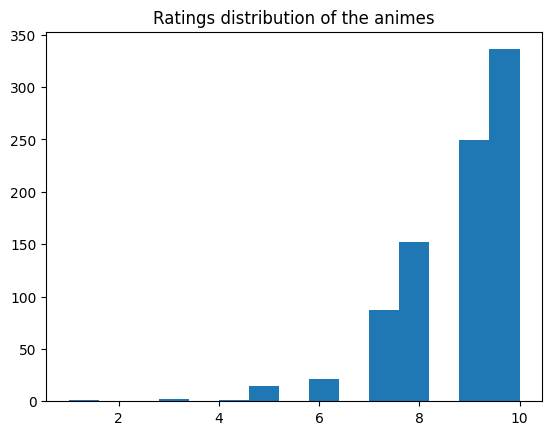

In [10]:
# the test function work as follow:
#   thest function give a feedback how person that love the anime love also the similar anime (predicted by us)
#   a) we get the similarity of the anime with the anime_id
#   b) we get the most similar 8 anime to the anime_id
#   c) we get the users that have loved the anime so with a very high importance
#   d) now we can check the mean rating of the users on the similar anime (only if the user has rated the anime)

# load anime just for plot 
anime = pd.read_csv(f"{dir_name}anime.csv")

def test_single_anime(anime_id, number_of_anime=8):
    similarities = anime_anime_matrix.loc[anime_id]
    most_similar_animes = similarities.sort_values(ascending=False).drop(index=anime_id)

    print("Anime name of most 10 similar animes to anime" + anime[anime['anime_id'] == anime_id]['name'].values[0])
    print(anime[anime['anime_id'].isin(most_similar_animes.head(number_of_anime).index)]['name'])

    users = user_anime_matrix[user_anime_matrix[anime_id] > 0.9].index
    print(f"Number of users that have seen the anime: {len(users)}")
    anime_ids = most_similar_animes.head(number_of_anime).index
    mean_importance = 0
    counter = 0
    ratings = []
    importance = []
    for user in users:
        for anime_id in anime_ids:
            if user_anime_matrix.loc[user, anime_id] != 0:
                mean_importance += user_anime_matrix.loc[user, anime_id]
                ratings.append(data[(data['user_id'] == user) & (data['anime_id'] == anime_id)]['user_rating'].values[0])
                importance.append(anime_anime_matrix.loc[813, anime_id])
                counter += 1

    print(f"Mean rating of the users: {np.mean(ratings)}")

    plt.hist(ratings, bins=15)
    plt.title("Ratings distribution of the animes")
    plt.show()


# one of the most famous anime hunter x hunter
anime_id = 138
test_single_anime(anime_id)

# a specific anime loved only by a few users is Kaiba from maasaky yuasa
anime_id = 3701
test_single_anime(anime_id)





### Test on Users
Now we will check how good is on test users

In [11]:

# ############################################
# STEP 1: Recommend top K animes
# ############################################

# we need a function that recommend the top K animes based on the input list of animes
# how it works:
#   a) for each anime in the input list we get the X most similar animes
#   b) we count the number of times that an anime is in the X most similar animes
#   c) we remove the input list from the recommendation
#   d) we get the top K animes that are recommended
#   e) we return the top K animes

NUMBER_OF_PREDICTIONS = 10

def recommend_top_animes(anime_list, X=15, K=NUMBER_OF_PREDICTIONS, similarity_matrix=anime_anime_matrix):
    recommendation_counts = Counter()

    for anime_id in anime_list:
        if anime_id in similarity_matrix.index:
            most_similar = similarity_matrix.loc[anime_id].drop(index=anime_id).nlargest(X).index.tolist()
            recommendation_counts.update(most_similar)

    for anime_id in anime_list:
        recommendation_counts.pop(anime_id, None)
    
    top_recommended_animes = [anime for anime, _ in recommendation_counts.most_common(K)]
    
    return top_recommended_animes



# ############################################
# STEP 2: Test the recommendation system
# ############################################
# in this part we just iterate on users, we get the top NUMBER_OF_ANIME animes that the user has seen
# we recommend the top animes to the user similiar to the animes that the user has seen
# we compute the mean rating of the user on the recommended animes if the user has rated the anime

GOOD_ANIME = 8
NUMBER_OF_ANIME = 10
total_rating_1 = 0
counter_1 = 0

pbar = tqdm(total=len(user_id_test), desc="Processing Test Users")

total_good = 0
total_bad = 0

for user_id in user_id_test:

    # get the top NUMBER_OF_ANIME animes that the user has seen
    anime_list = user_anime_matrix.loc[user_id].nlargest(NUMBER_OF_ANIME).index.tolist()
    top_animes_recommended = recommend_top_animes(anime_list)

    # compute the mean rating of the user on the recommended animes if the user has rated the anime
    total_rating_2 = 0
    counter_2 = 0
    for user in [user_id]:
        for anime_id in top_animes_recommended:
            if user_anime_matrix.loc[user, anime_id] != 0:
                rating = data[(data['user_id'] == user) & (data['anime_id'] == anime_id)]['user_rating'].values[0]
                total_rating_2 += rating
                
                if rating >= GOOD_ANIME:
                    total_good += 1
                else:
                    total_bad += 1
                counter_2 += 1


    pbar.update(1)

    if counter_2 == 0:
        continue
    
    total_rating_1 += total_rating_2/counter_2
    counter_1 += 1


print(f"Mean rating for all test users: {total_rating_1 / counter_1}")
print(f"Good recommendation: {total_good} Bad recommendation: {total_bad}, good rate {total_good / (total_good + total_bad)}")


# ############################################
# STEP 3: Get data to understand how good is the recommendation system
# ############################################

# Statistics 1 : mean rating of test users (not included the top NUMBER_OF_ANIME animes because our model can't use, not because is bad but because are the data used to recommend)

def mean_user_test(user_id, X):
    excluded_animes = user_anime_matrix.loc[user_id].nlargest(X).index.tolist()
    user_ratings = data[data['user_id'] == user_id]
    filtered_ratings = user_ratings[~user_ratings['anime_id'].isin(excluded_animes)]
    
    mean_rating = filtered_ratings['user_rating'].mean()
    
    return mean_rating


mean = 0
counter = 0
for user_id in user_id_test:
    mean_tmp = mean_user_test(user_id, NUMBER_OF_ANIME)
    if not np.isnan(mean_tmp):
        mean += mean_tmp
        counter += 1

print(f"Mean vote of test users: {mean / counter}")

# find total number of rating > 8 and rating < 8 to estimate hit rate of random recommendation
total_good = 0
total_bad = 0
for user_id in user_id_test:
    user_ratings = data[data['user_id'] == user_id]
    for rating in user_ratings['user_rating']:
        if rating >= GOOD_ANIME:
            total_good += 1
        else:
            total_bad += 1

print(f"RANDOM MODEL Good recommendation: {total_good} Bad recommendation: {total_bad}, good rate {total_good / (total_good + total_bad)}")


# Statistics 2 : mean if our model is powerful and predict perfect anime for users
# for every user we assume we predict the next 


def top_algoritm_comparison(user_id, X, Y):

    total_good = 0
    total_bad = 0

    user_ratings = data[data['user_id'] == user_id]
    sorted_ratings = user_ratings.sort_values(by='user_rating', ascending=False)
    excluded_top_x = sorted_ratings.iloc[X:]

    
    next_best_x = excluded_top_x.head(Y)

    for rating in next_best_x['user_rating']:
        if rating >= GOOD_ANIME:
            total_good += 1
        else:
            total_bad += 1
    
    improved_mean_rating = next_best_x['user_rating'].mean()
    
    return improved_mean_rating, total_good, total_bad


total_good = 0
total_bad = 0

mean = 0
counter = 0
for user_id in user_id_test:
    mean_tmp, good_tmo, bad_tmp = top_algoritm_comparison(user_id, NUMBER_OF_ANIME, NUMBER_OF_PREDICTIONS)
    if not np.isnan(mean_tmp):
        mean += mean_tmp
        counter += 1
        total_good += good_tmo
        total_bad += bad_tmp

print(f"Perfect result on test users: {mean / counter}")
print(f"Perfect recommendation: {total_good} Bad recommendation: {total_bad}, good rate {total_good / (total_good + total_bad)}")


# statistics 3: use a powerful and "cheat" model. This model predict only the top anime for the user and the other useless so mean is the best possible but not a good reccomandation
# the algoritm exclude the top X animes and predict the next best X animes



def top_algoritm_comparison2(user_id, X):
    total_bad = 0
    total_good = 0
    user_ratings = data[data['user_id'] == user_id]
    sorted_ratings = user_ratings.sort_values(by='user_rating', ascending=False)
    excluded_top_x = sorted_ratings.iloc[X:]
    next_best_x = excluded_top_x.head(1)
    for rating in next_best_x['user_rating']:
        if rating >= GOOD_ANIME:
            total_good += 1
        else:
            total_bad += 1
    improved_mean_rating = next_best_x['user_rating'].mean()
    return improved_mean_rating, total_good, total_bad

mean = 0
counter = 0

total_good = 0
total_bad = 0

for user_id in user_id_test:
    mean_tmp, good_tmo, bad_tmp = top_algoritm_comparison2(user_id, NUMBER_OF_ANIME)
    if not np.isnan(mean_tmp):
        mean += mean_tmp
        counter += 1
        total_good += good_tmo
        total_bad += bad_tmp

print(f"Perfect cheat result on test users: {mean / counter}")
print(f"Perfect cheat recommendation: {total_good} Bad recommendation: {total_bad}, good rate {total_good / (total_good + total_bad)}")



Processing Test Users:   0%|          | 0/2756 [00:00<?, ?it/s]

Mean rating for all test users: 8.351257230218614
Good recommendation: 7229 Bad recommendation: 1666, good rate 0.8127037661607645
Mean vote of test users: 7.672621454095946
RANDOM MODEL Good recommendation: 189439 Bad recommendation: 128631, good rate 0.5955890212846229
Perfect result on test users: 8.835796498893055
Perfect recommendation: 23053 Bad recommendation: 2114, good rate 0.9160011125680455
Perfect cheat result on test users: 9.163522012578616
Perfect cheat recommendation: 2536 Bad recommendation: 167, good rate 0.9382167961524233


# Nueral Network Model:

In [1]:
import os
import pprint
import tempfile
from typing import Dict, Text
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import seaborn as sns

In [11]:
W = 0.5

import pandas as pd
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')
#remouve nan values
anime = anime.dropna()
rating = rating.dropna()


rating['user_id'] = rating['user_id'].astype(str)
rating['anime_id'] = rating['anime_id'].astype(str)
#changing the type of anime id to string 
anime["anime_id"] = anime["anime_id"].astype(str)

unique_user_ids = list(rating.user_id.unique())
unique_anime_ids = list(anime.anime_id.unique())
unique_genres = list(anime.genre.unique())
unique_types = list(anime.type.unique())
unique_ratings = list(rating.rating.unique())

##normalising the ratings of each user to be between -1 and 1 by subtracting the mean of the ratings of each user and removing the -1
rating['rating'] = rating['rating'].astype(float)


rating = rating[rating['rating']!=-1]


rating['normalized_rating_1'] = rating.groupby('user_id')['rating'].transform(lambda x: (x - x.mean()))
rating['normalized_rating_2'] = rating.groupby('user_id')['rating'].transform(lambda x: (x - x.mean())/(x.max()-x.min()))
rating['normalized_rating_3'] = rating.groupby('user_id')['rating'].transform(lambda x: (x - x.mean())/(x.std()))

rating['binary_rating'] = rating['rating'].apply(lambda x: 1 if x>=0 else 0)

#renanaming the column rating to anime_rating

anime = anime.rename(columns={'rating':'anime_rating'})

#calculating the popularity of each anime by deviding the members by the top 90 percentile of the members

quantile = anime['members'].quantile(0.9)

anime['popularity'] = np.log(anime['members'])/np.log(anime['members'].max())

#adding an iteraction factor beween the rating and the popularity of the anime
anime['anime_rating_weighted'] = anime['popularity']*anime['anime_rating']*W + (1-W)*anime['anime_rating']

#remouving NAN values
rating = rating.dropna()


In [3]:
rating

,user_id,anime_id,rating,normalized_rating_1,normalized_rating_2,normalized_rating_3,binary_rating
156,3,20,8.0,0.434783,0.062112,0.280517,1
157,3,154,6.0,-1.565217,-0.223602,-1.009861,1
158,3,170,9.0,1.434783,0.204969,0.925706,1
159,3,199,10.0,2.434783,0.347826,1.570895,1
160,3,225,9.0,1.434783,0.204969,0.925706,1
...,...,...,...,...,...,...,...
7813730,73515,13659,8.0,-0.547486,-0.109497,-0.481274,1
7813731,73515,14345,7.0,-1.547486,-0.309497,-1.360336,1
7813732,73515,16512,7.0,-1.547486,-0.309497,-1.360336,1
7813733,73515,17187,9.0,0.452514,0.090503,0.397788,1


In [4]:
anime.head(20)

,anime_id,name,genre,type,episodes,anime_rating,members,popularity,anime_rating_weighted
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,0.882849,8.821150
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,0.982290,9.178004
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,0.842141,8.519903
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,0.970427,9.034406
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,0.862427,8.529918
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351,0.827525,8.360928
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855,0.937273,8.843650
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679,0.816976,8.276326
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534,0.809281,8.232227
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109,0.817360,8.278077


<Axes: xlabel='anime_rating_weighted'>

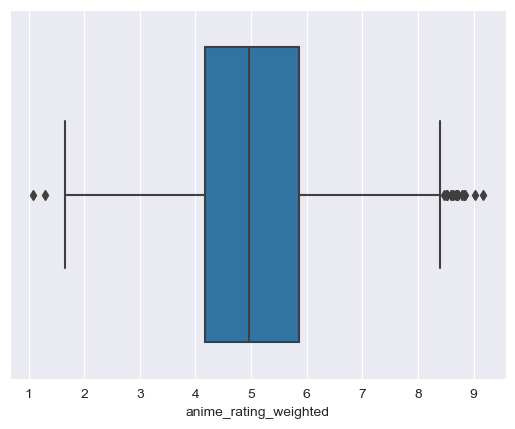

In [5]:
#distribution of binary ratings using a histogram
sns.boxplot(x=anime['anime_rating_weighted'])

<Axes: xlabel='popularity'>

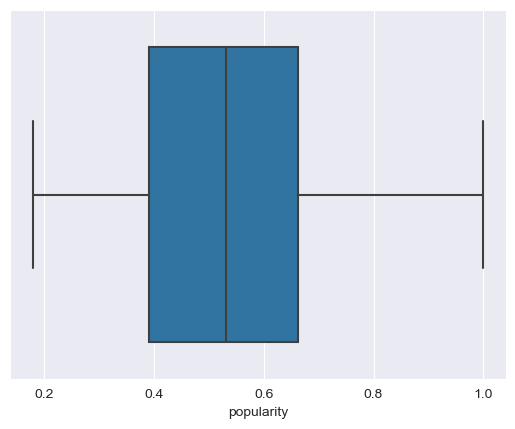

In [6]:
sns.boxplot(x=anime['popularity'])

<Axes: xlabel='normalized_rating_2', ylabel='Count'>

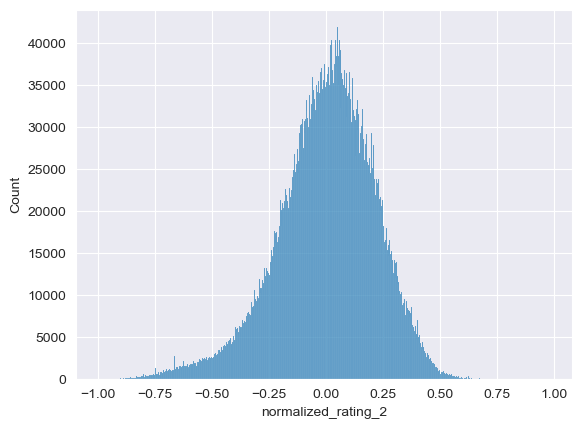

In [7]:
sns.histplot(x=rating['normalized_rating_2'])

<Axes: xlabel='normalized_rating_3', ylabel='Count'>

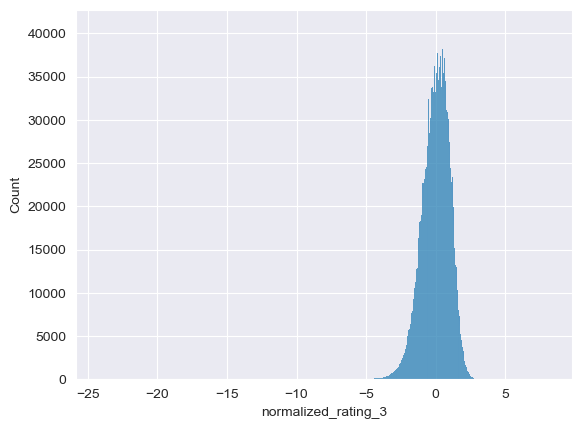

In [8]:
sns.histplot(x=rating['normalized_rating_3'])

<Axes: xlabel='normalized_rating_1', ylabel='Count'>

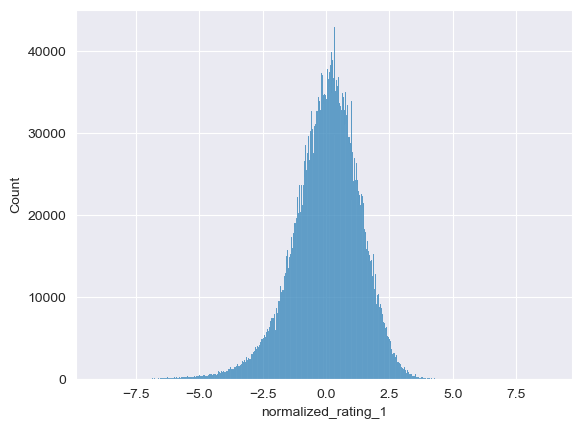

In [9]:
sns.histplot(x=rating['normalized_rating_1'])

<Axes: xlabel='anime_rating'>

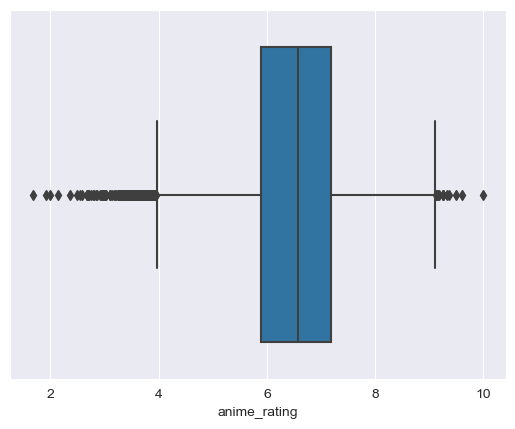

In [13]:
sns.boxplot(x=anime['anime_rating'])

In [14]:
unique_user_ids = np.unique(unique_user_ids)
unique_anime_ids = np.unique(unique_anime_ids)
unique_genres = np.unique(unique_genres)
unique_types = np.unique(unique_types)

In [15]:
#preaparing the data for the model
columns = ['anime_id','genre',"anime_rating","anime_rating_weighted","type"]
data = rating.merge(anime[columns], on='anime_id')
#dropping the columns that are not needed
print(len(data))


6304676


In [16]:

ratings = tf.data.Dataset.from_tensor_slices(dict(rating))
data = tf.data.Dataset.from_tensor_slices(dict(data))

print(data)
#6304676

<_TensorSliceDataset element_spec={'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'anime_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'rating': TensorSpec(shape=(), dtype=tf.float64, name=None), 'normalized_rating_1': TensorSpec(shape=(), dtype=tf.float64, name=None), 'normalized_rating_2': TensorSpec(shape=(), dtype=tf.float64, name=None), 'normalized_rating_3': TensorSpec(shape=(), dtype=tf.float64, name=None), 'binary_rating': TensorSpec(shape=(), dtype=tf.int64, name=None), 'genre': TensorSpec(shape=(), dtype=tf.string, name=None), 'anime_rating': TensorSpec(shape=(), dtype=tf.float64, name=None), 'anime_rating_weighted': TensorSpec(shape=(), dtype=tf.float64, name=None), 'type': TensorSpec(shape=(), dtype=tf.string, name=None)}>


In [17]:
tf.random.set_seed(42)
shuffled = data.shuffle(300_000,seed=42, reshuffle_each_iteration=False)

train = shuffled.take(240_000)
test = shuffled.skip(240_000).take(60_000)

In [18]:


class RankingModel(tf.keras.Model):

  def __init__(self,binary=False):
    super().__init__()
    self.binary = binary
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.anime_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_anime_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_anime_ids) + 1, embedding_dimension)
    ])
    self.genre_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_genres, mask_token=None),
      tf.keras.layers.Embedding(len(unique_genres) + 1, embedding_dimension)
    ])
    #one hot vector for the type
    
    
    self.type_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_types, mask_token=None),
      tf.keras.layers.Embedding(len(unique_types) + 1, 4)
    
    ])
    
    
    self.item_importance = tf.keras.Sequential([
        
        tf.keras.layers.Dense(64, activation="linear"),
        
        tf.keras.layers.Dense(32, activation="linear"),
      
      
    ])

    # Compute predictions.
    if binary:
      self.ratings = tf.keras.Sequential([
       
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l2(0.01))
      ])
    else:
      self.ratings = tf.keras.Sequential([
        
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01))
      ])
    
      
  def item_embedding(self, anime_id, genre, type):
    anime_embedding = self.anime_embeddings(anime_id)
    genre_embedding = self.genre_embeddings(genre)
    type_embedding = self.type_embeddings(type)
    return (anime_embedding + genre_embedding + type_embedding) / 3.0

  def call(self, inputs):

    user_id, anime_id, genre,rating, popularity ,type= inputs
    

    
    user_embedding = self.user_embeddings(user_id)
    anime_embedding = self.anime_embeddings(anime_id)
    
    #converting the rating to a tensor
    anime_rating = tf.convert_to_tensor(rating, dtype=tf.float32)
    anime_rating = tf.expand_dims(anime_rating, axis=1)
    
    anime_popularity = tf.convert_to_tensor(popularity, dtype=tf.float32)
    anime_popularity = tf.expand_dims(anime_popularity, axis=1)
    
    genre_embedding = self.genre_embeddings(genre)
    
    type_embedding = self.type_embeddings(type)

  
    
    item = tf.concat([anime_embedding, genre_embedding,type_embedding], axis=1)
    item = self.item_importance(item)
    
    return self.ratings(tf.concat([user_embedding,item,anime_popularity], axis=1))

In [19]:
task = tfrs.tasks.Ranking(
  loss = tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

task_binary = tfrs.tasks.Ranking(
  loss = tf.keras.losses.BinaryCrossentropy(),
  metrics=[tf.keras.metrics.BinaryAccuracy()]
)


In [20]:
class AnimeModel(tfrs.models.Model):

  def __init__(self,binary=False):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel(binary)
    self.binary = binary
    if binary:
      self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
      )
    else:
      self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss = tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["anime_id"], features["genre"], features["anime_rating"],features["anime_rating_weighted"],features["type"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    """labels = features.pop("rating")

    rating_predictions = self(features)
    """
    features = features.copy()  # Make a shallow copy of features
    if self.binary:
      labels = features.pop("binary_rating")
    else:
      labels = features.pop("rating")
        
    
    rating_predictions = self(features)

    # The task computes the loss and the metrics.
  
    return self.task(labels=labels, predictions=rating_predictions)

    

In [21]:
model = AnimeModel(binary=False)

In [22]:

cached_train = train.take(240_000).batch(32_768).cache()
cached_test = test.batch(16_384).cache()

"""learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.1)"""

model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1,clipnorm=0.001))

In [23]:
#adding the learning rate 
two_layer_history = model.fit(cached_train, epochs=700,validation_data=cached_test)

Epoch 1/700


/Users/yassine/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'anime_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2024-05-22 09:34:07.829969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 200434 of 300000
2024-05-22 09:34:27.828305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 226619 of 300000
2024-05-22 09:34:37.829026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 232040 of 300000
2024-05-22 09:34:47.829753: I tensorflow/c

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 62.1941 - regularization_loss: 1.7475 - root_mean_squared_error: 7.9082 - total_loss: 63.9416

2024-05-22 09:38:11.104363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 226723 of 300000
2024-05-22 09:38:31.105417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 263423 of 300000
2024-05-22 09:38:51.104221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 278305 of 300000
2024-05-22 09:39:01.104671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 283661 of 300000
2024-05-22 09:39:21.103379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 298047 of 300000
2024-05-22 09:39:21.727542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


8/8 ━━━━━━━━━━━━━━━━━━━━ 604s 55s/step - loss: 62.0955 - regularization_loss: 1.7475 - root_mean_squared_error: 7.9064 - total_loss: 63.8430 - val_loss: 60.9061 - val_regularization_loss: 1.7475 - val_root_mean_squared_error: 7.8085 - val_total_loss: 62.6536
Epoch 2/700
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 60.4011 - regularization_loss: 1.7475 - root_mean_squared_error: 7.7953 - total_loss: 62.1485 - val_loss: 59.3174 - val_regularization_loss: 1.7475 - val_root_mean_squared_error: 7.7060 - val_total_loss: 61.0649
Epoch 3/700
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 58.8277 - regularization_loss: 1.7475 - root_mean_squared_error: 7.6928 - total_loss: 60.5753 - val_loss: 57.7782 - val_regularization_loss: 1.7475 - val_root_mean_squared_error: 7.6052 - val_total_loss: 59.5258
Epoch 4/700
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 57.2778 - regularization_loss: 1.7475 - root_mean_squared_error: 7.5909 - total_loss: 59.0253 - val_loss: 56.2571 - val_regularization_loss: 1.

In [24]:


model.evaluate(cached_test, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9140 - regularization_loss: 1.5322 - root_mean_squared_error: 1.3844 - total_loss: 3.4462


{'loss': 1.8964242935180664,
 'regularization_loss': 1.532231330871582,
 'root_mean_squared_error': 1.3857735395431519,
 'total_loss': 3.4286556243896484}

In [25]:

accuracy = two_layer_history.history
loss = accuracy['loss']

val_loss = accuracy['val_loss']


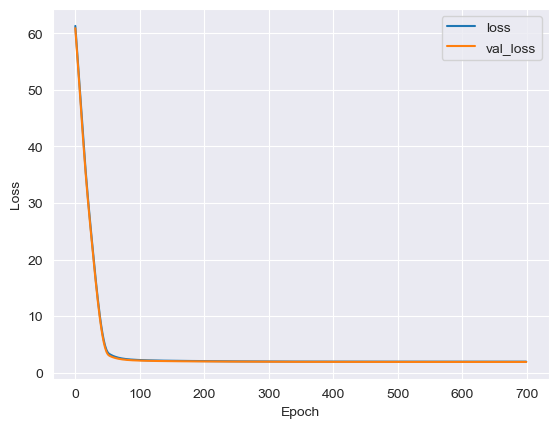

In [26]:
#plotting the loss
import matplotlib.pyplot as plt
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plotting other metrics 


In [32]:
#saving the model
import tempfile
model.save("anime__.keras")

In [31]:
#loading the model
model = tf.keras.models.load_model("anime_model.keras")

TypeError: Could not locate class 'AnimeModel'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'AnimeModel', 'config': {'trainable': True, 'dtype': 'float32'}, 'registered_name': 'AnimeModel', 'build_config': {'input_shape': {'user_id': [None], 'anime_id': [None], 'normalized_rating_1': [None], 'normalized_rating_2': [None], 'normalized_rating_3': [None], 'binary_rating': [None], 'genre': [None], 'anime_rating': [None], 'anime_rating_weighted': [None], 'type': [None]}}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adagrad', 'config': {'name': 'adagrad', 'learning_rate': 0.10000000149011612, 'weight_decay': None, 'clipnorm': 0.001, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'initial_accumulator_value': 0.1, 'epsilon': 1e-07}, 'registered_name': None}, 'loss': None, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}

<Axes: >

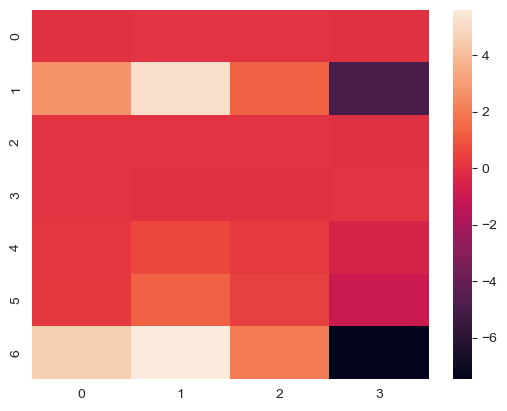

In [33]:
#print the weights of the model and build a heat map out of it 
weights = model.ranking_model.get_weights()
sns.heatmap(weights[3])

In [34]:
rating_new = pd.read_csv('rating.csv')
rating_new['user_id'] = rating_new['user_id'].astype(str)
rating_new['anime_id'] = rating_new['anime_id'].astype(str)
rating_new = rating_new.dropna()
rating_new['rating'] = rating_new['rating'].astype(float)


In [35]:
from sklearn.metrics.pairwise import cosine_similarity
#getting the top k movies for a user using similarity model of the embeddings
# Get the embeddings of the animes for the first user in the dataset
user_id = "3"
print(user_id)
user_id = tf.convert_to_tensor([user_id])
anime_embeddings = model.ranking_model.anime_embeddings(anime['anime_id']) 
user_embedding = model.ranking_model.user_embeddings(user_id)  

# Compute the similarity between user and anime embeddings using cosine similarity 

similarity = cosine_similarity(user_embedding, anime_embeddings)
print(similarity)
similarity = similarity[0]


#similarity = tf.reduce_sum(user_embeddings * anime_embeddings, axis=1)
# Get the top 10 most similar animes

top_animes = pd.DataFrame({
    'anime_id': anime['anime_id'],
    'similarity': similarity
})
top_animes = top_animes.sort_values(by='similarity', ascending=False).head(10)
top_animes = top_animes.merge(anime, on='anime_id')

print(user_id)
print(top_animes)

#cheking how many of the top animes are in the users ratings
top_animes = top_animes.merge(rating[rating["user_id"]=="3"], on='anime_id')
print(top_animes[['anime_id', 'name']]) 

#printing the top 10 users that are similar to the user
unique_user_ids = unique_user_ids
user_embeddings = model.ranking_model.user_embeddings(unique_user_ids)

similarity = cosine_similarity(user_embedding, user_embeddings)


top_users = pd.DataFrame({
    'user_id': unique_user_ids,
    'similarity': similarity[0]
})
top_users = top_users.sort_values(by='similarity', ascending=False).head(2)
print("#############")
print(top_users)
#printing the second uer that is similar to the user

#in order to verify the results we can check the ratings of the second top users and see if they are similar to the user
top_users_2 = top_users.merge(rating_new[rating_new["user_id"]==top_users.iloc[1]['user_id']], on='user_id')
print(top_users_2[['user_id', 'rating','anime_id']])
top_users_3 = top_users.merge(rating_new[rating_new["user_id"]==top_users.iloc[0]['user_id']], on='user_id')
#intersectting woth top_users_2 and top_users_3 using the anime_id
top_users_4 = top_users_3.merge(top_users_2, on='anime_id')

print(top_users_4[["user_id_x","user_id_y","anime_id","rating_x","rating_y"]])


#createing a function that will return the top k similar users to a user

def top_k_similar_users(user_id,model,k=10):
    user_id = tf.convert_to_tensor([user_id])
    user_embeddings = model.ranking_model.user_embeddings(unique_user_ids)
    user_embedding = model.ranking_model.user_embeddings(user_id)  

    # Compute the similarity between user and anime embeddings using cosine similarity 
    
    similarity = cosine_similarity(user_embedding, user_embeddings)
    similarity = similarity[0]
    
    top_users = pd.DataFrame({
        'user_id': unique_user_ids,
        'similarity': similarity,
    })
    
    top_users = top_users.sort_values(by='similarity', ascending=False).head(k)
    return top_users.iloc[1:]
print(top_k_similar_users("3",model,10))

3
[[-0.00149576  0.10671143 -0.12763311 ... -0.02848164 -0.08939219
   0.03040071]]
tf.Tensor([b'3'], shape=(1,), dtype=string)
  anime_id  similarity                                               name  \
0      401    0.632949  Rurouni Kenshin: Meiji Kenkaku Romantan - Seis...   
1    16838    0.590925                            Gaegujang-i Cheonsadeul   
2    33994    0.546763                                   Servamp Specials   
3     1854    0.546299                          Rockman Hoshi ni Negai wo   
4     3138    0.539889                                  Solty Rei Special   
5     2734    0.539804             Mazinkaiser: Shitou! Ankoku Dai Shogun   
6     3411    0.531255                                  Haitoku no Shoujo   
7    17679    0.531181                                              Gambo   
8      246    0.514920                              Groove Adventure Rave   
9    31736    0.511880                   Valkyrie Drive: Mermaid Specials   

                        

In [36]:
#importing eqlidian distance


def similarity(anime_id,model,anime,k=10):
    anime_id = tf.convert_to_tensor([anime_id])
    
    anime_embeddings = model.ranking_model.anime_embeddings(anime['anime_id'])
    anime_embedding = model.ranking_model.anime_embeddings(anime_id)
    
    anime_genre_tensor = tf.convert_to_tensor([anime[anime['anime_id'] == anime_id]['genre'].values[0]])
    genre_embeddings = model.ranking_model.genre_embeddings(anime['genre'])
    genre_embedding = model.ranking_model.genre_embeddings(anime_genre_tensor)
    
    
    anime_type_tensor = tf.convert_to_tensor([anime[anime['anime_id'] == anime_id]['type'].values[0]])
    type_embeddings = model.ranking_model.type_embeddings(anime['type'])
    type_embedding = model.ranking_model.type_embeddings(anime_type_tensor)
    
    item = tf.concat([anime_embedding, genre_embedding,type_embedding], axis=1)
    item = model.ranking_model.item_importance(item)
    
    items = tf.concat([anime_embeddings, genre_embeddings,type_embeddings], axis=1)
    items = model.ranking_model.item_importance(items)
    
    similarity = cosine_similarity(item, items)
    distance = tf.norm(item-items, axis=1)
    
    similarity = similarity[0]
    top_anime = pd.DataFrame({
        'anime_id': anime['anime_id'],
        'similarity': similarity,
    })
    top_anime = top_anime.sort_values(by='similarity', ascending=False).head(k)
    return top_anime

top_items = similarity("11061",model,anime)

top_items = top_items.sort_values(by='similarity', ascending=False).head(10)
top_items = top_items.merge(anime, on='anime_id')

print(top_items[['anime_id', 'name','similarity', 'genre' , 'type' ]])





  anime_id                          name  similarity  \
0    11061        Hunter x Hunter (2011)    1.000000   
1      136               Hunter x Hunter    0.999933   
2      967                 Hokuto no Ken    0.999914   
3    12091                      X Bomber    0.999911   
4    19991            Tobidase! Bacchiri    0.999908   
5     6425                  Weiß Survive    0.999906   
6    27943                 Nano Invaders    0.999904   
7    15313      Wooser no Sono Higurashi    0.999903   
8     5079        Kurokami The Animation    0.999903   
9    27737  Battle Spirits: Burning Soul    0.999901   

                                           genre type  
0        Action, Adventure, Shounen, Super Power   TV  
1        Action, Adventure, Shounen, Super Power   TV  
2   Action, Drama, Martial Arts, Sci-Fi, Shounen   TV  
3  Action, Adventure, Kids, Mecha, Sci-Fi, Space   TV  
4                          Comedy, Kids, Mystery   TV  
5                            Comedy, Ecchi, Gam

In [37]:

#putting this into a fucntion that takes the model, the user id and dataframe of the animes and returns the animes rated 

def rate(model,user_id,anime,candidates=None):
    
    anime['user_id'] = user_id
    #if candidates is not none then we will only predict the ratings for the candidates
    if candidates is not None:
        anime = anime[anime['anime_id'].isin(candidates)]
    # Convert DataFrame to TensorFlow dataset
    anime_features = tf.data.Dataset.from_tensor_slices(dict(anime))
    
    anime_features_1 = anime_features.batch(len(anime))
    # Predict ratings for all animes
    rating_prediction = model.predict(anime_features_1)
    anime_features = anime_features.batch(1)
    
    predictions = []
    i=0
    for batch in anime_features:
        anime_id_tensor = batch['anime_id']
        """user_id_tensor = batch['user_id']
        
        genre_tensor = batch['genre']
        rating_tensor = batch['anime_rating']
        anime_rating_weighted = batch['anime_rating_weighted']
        anime_type = batch["type"]
        """
   
        """rating_prediction = model({
            "user_id": user_id_tensor,
            "anime_id": anime_id_tensor,
            "genre": genre_tensor,
            "anime_rating": rating_tensor,
            "anime_rating_weighted": anime_rating_weighted,
            "type":anime_type

        })"""
    
        #rating_prediction = model.predict(batch,verbose=0)
    
        predictions.append({
            'anime_id': anime_id_tensor.numpy()[0].decode('utf-8'), 
            'predicted_rating': rating_prediction[i][0],
        })
        i+=1
        
        
    

    # Create a new DataFrame with the predictions
    predictions_df = pd.DataFrame(predictions)
    

    # Print the DataFrame with anime IDs and their predicted ratings

    return predictions_df

"""personal_rating = rating_new[rating_new["user_id"]==user_id]
p_rating = personal_rating[personal_rating['anime_id']==anime_id_tensor.numpy()[0].decode('utf-8')]['rating']
  "oroginal_rating": p_rating.values[0] if len(p_rating)>0 else "No rating"
    })

"""
ratings= rate(model,"5",anime)
########
## testing the model on a pesimistic user as you can see it's accurate except for one value
########
ratings = ratings.merge(anime, on='anime_id')
watched_list = rating_new[rating_new["user_id"]=="5"]
watched_list = watched_list.merge(ratings, on='anime_id')
watched_list = watched_list.sort_values(by='predicted_rating', ascending=False).head(15)
print(watched_list[['anime_id',"predicted_rating","rating" ]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


2024-05-22 09:48:39.302893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


    anime_id  predicted_rating  rating
214     9253          9.076240     9.0
29       199          8.931370     8.0
94      1535          8.812116     4.0
423    23273          8.808039     8.0
80       918          8.781334     9.0
225     9989          8.747668     7.0
452    28891          8.743995     9.0
388    20583          8.737746     8.0
334    16894          8.672494     5.0
223     9969          8.648006     9.0
309    15335          8.620980    10.0
375    19815          8.601109     1.0
36       245          8.566617    10.0
350    18115          8.523607     7.0
177     6547          8.511369     3.0


In [38]:
####
# The strategy is as follows: 
# if we want to recommend something to a user, we will first get the top k similar users to the user.
# then we will pick all the animes that the user interacted with 
# then we can get similar animes to the animes that the user interacted with
# and the final step is to re rate everything using the model 
# and return the top k animes that the user will like
####

import tqdm
def recommend_collaborative(model,user_id,anime,number_of_animes=10,number_of_users=10):
    #get the top k similar users to the user
    number_of_users+=1
    top_users = top_k_similar_users(user_id,model,number_of_users)
    
    #get the animes that the users interacted with | similar users it means that they interacted with the same animes and moslty rated them the same
    #but sometimes users can have a prefrence for a specific genre or type of anime
    # so we pick every anime that the user interacted with and reratethem using the model
    
    user_animes = rating_new[rating_new["user_id"].isin(top_users['user_id'])]
    #get the top k similar animes to the animes that the user interacted with
    top_animes = user_animes[['anime_id']]
    
    
    """pbar = tqdm.tqdm(total=len(user_animes))
    for anime_id in user_animes['anime_id']:
        top_animes.append(similarity(anime_id,model,anime,k=1))
        pbar.update(1)
        top_animes = pd.concat(top_animes)
    #get the top k animes that the user will like
    top_animes = top_animes.sort_values(by='similarity', ascending=False).head(number_of_animes)
    top_animes = top_animes.merge(anime, on='anime_id')
    """
    anime = rate(model,user_id,anime,candidates=top_animes['anime_id'].values)
    
    return anime.head(number_of_animes)

####
#testing the function on a user
####
recomendations = recommend_collaborative(model,"3",anime,20,4)
print(recomendations)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
   anime_id  predicted_rating
0      5114          9.328299
1     11061          8.959300
2      2904          8.921336
3       199          8.942800
4     23273          8.818769
5      1575          8.828962
6       164          8.819529
7     11665          8.294763
8       431          8.733859
9      1535          8.830276
10    20583          8.749523
11    10379          8.255314
12    31043          8.563369
13    31240          8.518665
14     5300          8.251017
15     9989          8.761314
16    24415          8.522746
17    10408          8.772479
18    28171          8.471521
19    22535          8.515708


2024-05-22 09:48:39.991175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [39]:
# These are the animes that he rated and the predicted rating for the user
recomendation = recomendations.merge(anime, on='anime_id')
recomendation = recomendation.merge(rating_new[rating_new["user_id"]=="3"], on='anime_id')
print(recomendation[['anime_id', 'name','predicted_rating','rating',"genre","type"]])


  anime_id                                               name  \
0     5114                   Fullmetal Alchemist: Brotherhood   
1      199                      Sen to Chihiro no Kamikakushi   
2     1535                                         Death Note   
3    20583                                          Haikyuu!!   
4    31043                            Boku dake ga Inai Machi   
5     9989  Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...   
6    24415                        Kuroko no Basket 3rd Season   
7    10408                                 Hotarubi no Mori e   
8    28171                                 Shokugeki no Souma   

   predicted_rating  rating  \
0          9.328299    10.0   
1          8.942800    10.0   
2          8.830276    10.0   
3          8.749523     9.0   
4          8.563369    10.0   
5          8.761314    10.0   
6          8.522746    10.0   
7          8.772479     7.0   
8          8.471521    10.0   

                                      

In [40]:
#creating a function that will take recomendations and then calculate the mean rating 
def mean_rating(user_id,recomendations,anime,rating_new):
    recomendations = recomendations.merge(anime, on='anime_id')
    recomendations = recomendations.merge(rating_new[rating_new["user_id"]==user_id], on='anime_id')
    return recomendations[recomendations['rating']>0]["rating"].mean()
##testing the function
print("mean rating: ",mean_rating("3",recomendations,anime,rating_new))


mean rating:  9.555555555555555


In [41]:
print(unique_user_ids)
#take a randon sample of 10 users
users = np.random.choice(unique_user_ids,100)
print(users)

['1' '10' '100' ... '9997' '9998' '9999']
['55645' '33637' '38557' '4895' '48866' '64793' '43072' '25900' '38635'
 '41641' '45590' '54122' '6617' '55952' '36297' '8223' '68067' '46621'
 '31582' '49783' '9206' '52780' '64178' '44170' '38087' '61297' '7869'
 '71526' '995' '72048' '37219' '350' '3399' '50473' '26806' '68884'
 '45825' '39440' '33491' '60271' '71344' '35884' '5518' '4127' '69156'
 '56058' '41144' '66645' '68257' '12430' '44150' '73169' '20219' '56757'
 '70920' '51528' '55262' '19103' '24610' '1329' '33648' '47426' '33769'
 '48641' '44351' '46280' '42472' '7298' '12692' '26366' '588' '22832'
 '58385' '18084' '35490' '43133' '48889' '35261' '53110' '57725' '45119'
 '29022' '58198' '20572' '49292' '470' '8143' '14326' '45122' '42564'
 '9118' '52651' '1805' '12531' '31344' '34910' '48230' '3633' '53120'
 '34984']


In [42]:
import warnings
warnings.filterwarnings('ignore')
#calculating the mean rating for all the users in the test set
def mean_rating_all_users(users,model,anime,rating_new):
    #users = users['user_id'].unique()
    mean_ratings = []
    pbar = tqdm.tqdm(total=len(users))
    for user in users:
        recomendations = recommend_collaborative(model,user,anime,100,10)
        mean_ratings.append(mean_rating(user,recomendations,anime,rating_new))
        pbar.update(1)
    return mean_ratings
#users are ther test users



In [ ]:
mean_ratings = mean_rating_all_users(users,model,anime,rating_new);

In [44]:
print(mean_ratings)

[7.8, 8.0, 8.73913043478261, 10.0, 9.25, 8.9, nan, 7.166666666666667, 8.444444444444445, 9.294117647058824, 7.6, 9.666666666666666, 8.6, 8.88888888888889, 7.7272727272727275, 8.272727272727273, 8.7, 9.333333333333334, 8.090909090909092, 9.444444444444445, 9.8, 8.6, 8.380952380952381, 8.272727272727273, 9.4, 9.5, 8.461538461538462, 8.75, 8.644444444444444, nan, 8.5, 8.758620689655173, 8.705882352941176, 8.666666666666666, nan, 10.0, 9.571428571428571, 8.5, 9.214285714285714, 8.4, 9.0, 8.818181818181818, 10.0, 7.666666666666667, 8.25, nan, 8.733333333333333, 9.0, 9.0, 8.588235294117647, 9.0, 9.666666666666666, 8.0, 7.590909090909091, 9.714285714285714, 9.0, 9.25, 9.6, 10.0, 7.75, 9.454545454545455, 10.0, 10.0, 8.222222222222221, 9.166666666666666, 9.7, nan, nan, 9.285714285714286, 8.0, 9.333333333333334, 8.5, 9.0, 9.866666666666667, 8.857142857142858, 7.666666666666667, 8.0, 9.666666666666666, nan, 9.5, 9.416666666666666, 8.4, 10.0, 8.2, 8.642857142857142, nan, 10.0, 6.928571428571429, 9

In [45]:
mean_rating = [i for i in mean_ratings if i is not np.nan]
print("the mean rating for all the users is: ", np.array(mean_rating).mean())

the mean rating for all the users is:  8.854269019605422
